### Data

In [1]:
import itertools
import numpy as np

from load_data import CodeNamesData

In [2]:
data = CodeNamesData('words_categories.txt')

In [3]:
sample_field = data.sample_field()

In [4]:
import fasttext
ft = fasttext.load_model('cc.en.300.bin')

word_vectors = {word: ft.get_word_vector(word) for word in data.vocabulary}

In [5]:
def get_training_examples(field):
    examples = []
    blue_cat = set(field['blue'])
    for cat in field['blue']:
        example = {}
        example['chosen_blue'] = field['blue'][cat]
        example['other_blue'] = list(itertools.chain(*[field['blue'][c] for c in (blue_cat - set([cat]))]))
        example['neutral'] = field['neutral']
        example['black'] = field['black']
        examples.append((example, cat))
    return examples

In [6]:
def embed_examples(examples, word2embedding, pad_chosen=True):
    result = []
    for example, label in examples:
        embed_example = {'blue': []}
        for w in example['chosen_blue']:
            if pad_chosen:
                embed_example['blue'].append(np.concatenate([np.ones(1).astype(np.float32), word2embedding[w]]))
            else:
                embed_example['blue'].append(word2embedding[w])
                
        for w in example['other_blue']:
            if pad_chosen:
                embed_example['blue'].append(np.concatenate([np.zeros(1).astype(np.float32), word2embedding[w]]))
            else:
                embed_example['blue'].append(word2embedding[w])
        embed_example['blue'] = np.array(embed_example['blue'])
        embed_example['neutral'] = np.array([word2embedding[w] for w in example['neutral']])
        embed_example['black'] = word2embedding[example['black']]
        result.append((embed_example, label))
    return result

In [7]:
category2idx = {category: i for i, category in enumerate(data.categories)}
idx2category = {v: k for k, v in category2idx.items()}

In [8]:
from copy import deepcopy

def get_examples_for_bob(examples):
    bob_examples = []
    field = []
    for color in examples[0][0]:
        if color == 'black':
            field.append(examples[0][0][color])
        else:
            field.extend(examples[0][0][color])
    
    for field_info, _ in examples:
        np.random.shuffle(field)
        answers = []
        for a in field_info['chosen_blue']:
            answers.append(field.index(a))
        bob_examples.append((deepcopy(field), answers))
    return bob_examples

In [9]:
def get_batch(n_fields, word2embedding, pad_chosen=True):
    get_batch.fields = []
    colored_fields_examples = {'blue': [], 'neutral': [], 'black': [], 'label': []}
    fields_examples = {'field': [], 'label': [], 'field_words': []}
    fields_embs = []
    for i in range(n_fields):
        field = data.sample_field()
        examples = get_training_examples(field)
        bob_examples = get_examples_for_bob(examples)
        for bob_example, answers in bob_examples:
            fields_examples['field'].append([word2embedding[w] for w in bob_example])
            fields_examples['field_words'].append(bob_example)
            fields_examples['label'].append(answers)
        
        fields_embs.extend(embed_examples(examples, word2embedding, pad_chosen))
        # get_batch.bob_fields = bob_examples
        get_batch.fields.append(field)
    
    
    for field, label in fields_embs:
        np.random.shuffle(field['blue'])
        np.random.shuffle(field['neutral'])
        colored_fields_examples['blue'].append(field['blue'])
        colored_fields_examples['neutral'].append(field['neutral'])
        colored_fields_examples['black'].append(field['black'])
        colored_fields_examples['label'].append(category2idx[label])
    colored_fields_examples['blue'] = np.array(colored_fields_examples['blue'])
    colored_fields_examples['neutral'] = np.array(colored_fields_examples['neutral'])
    colored_fields_examples['black'] = np.array(colored_fields_examples['black'])
    
    fields_examples['field'] = np.array(fields_examples['field'])
    return colored_fields_examples, fields_examples

In [12]:
from pprint import pprint
# pprint(get_batch.fields)

### Network

In [13]:
import torch
import torch.nn.functional as F
from torch import nn, optim

In [14]:
class AliceNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, categories_embs, n_layers, n_hints, 
                 pad_chosen=True):
        super().__init__()
        if pad_chosen:
            self.emb_blue = nn.LSTM(input_size + 1, hidden_size, n_layers)
        else:
            self.emb_blue = nn.LSTM(input_size, hidden_size, n_layers)
        self.emb_neutral = nn.LSTM(input_size, hidden_size, n_layers)
        self.emb_black = nn.Linear(input_size, hidden_size)
        self.hint_producer = nn.Sequential(nn.Linear(hidden_size * 3, 512),
                                           nn.ReLU(),
                                           nn.Linear(512, 300))
                                           # nn.ReLU(),
                                           # nn.Linear(128, n_hints))
        self.categories_embs = categories_embs
    
    def forward(self, blue_words, neutral_words, black_words):
        blue_embs, _ = self.emb_blue(blue_words)
        neutral_embs, _ = self.emb_neutral(neutral_words)
        black_embs = F.relu(self.emb_black(black_words))
        
        out = torch.cat([blue_embs[-1], neutral_embs[-1], black_embs], dim=1)
        out = self.hint_producer(out)
        out = torch.mm(out, self.categories_embs.T)
        return out

In [15]:
class BobNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, 
                 n_layers, field_size):
        super().__init__()
        self.emb_field = nn.LSTM(input_size, hidden_size, n_layers)
        self.emb_hint = nn.Linear(input_size, hidden_size)
        
        
        self.emb = nn.Sequential(nn.Linear(hidden_size * 2, 512),
                                        nn.ReLU(),
                                        nn.Linear(512, 300))
    
    def forward(self, field, hint):
        field_emb, _ = self.emb_field(field)
        hint_emb = self.emb_hint(hint)
        
        out = torch.cat([field_emb[-1], hint_emb], dim=1)
        out = self.emb(out)
        # print(out.shape)
        # print(field.shape)
        res = []
        for i in range(field.shape[1]):
            res.append(torch.mm(out[i].view(1, -1), field.permute(1, 0, 2)[i].T))
        # out = torch.mm(out[i], field.permute(1, 0, 2)[i].T)
        return torch.cat(res)

In [16]:
categories_embs = np.array([ft.get_word_vector(word) for word in data.categories])
categories_embs = torch.as_tensor(categories_embs)

In [17]:
alice_b, bob_b = get_batch(8, word_vectors)

In [18]:
alice_net = AliceNetwork(300, 256, categories_embs, 2, 25)
bob_net = BobNetwork(300, 256, 2, 25)

In [19]:
blue_t = torch.as_tensor(alice_b['blue'], dtype=torch.float32)
neutral_t = torch.as_tensor(alice_b['neutral'], dtype=torch.float32)
black_t = torch.as_tensor(alice_b['black'], dtype=torch.float32)

In [20]:
out = alice_net(blue_t.permute(1, 0, 2), neutral_t.permute(1, 0, 2), black_t)

In [21]:
field_t = torch.as_tensor(bob_b['field'], dtype=torch.float32)

hint = np.random.choice(data.categories, size=field_t.shape[0])
hint_t = torch.as_tensor([ft.get_word_vector(h) for h in hint], dtype=torch.float32)

In [22]:
bob_out = bob_net(field_t.permute(1, 0, 2), hint_t)

In [23]:
bob_out[0].topk(3)[1]

tensor([ 3, 20, 14])

In [28]:
bob_out.shape

torch.Size([24, 25])

In [37]:
def sample_bob_action(qvalues_tensor, epsilon, n_actions=25, k=1):
    actions = qvalues_tensor.topk(k)[1].squeeze()
    for i in range(len(actions)):
        if epsilon > np.random.random():
            actions[i] = np.random.choice(n_actions)
    return actions.detach()

In [38]:
sum(sample_bob_action(bob_out[0], 0.3, k=3).numpy() == [7, 21, 2])

0

In [39]:
bob_out[0].topk(1)[1].squeeze()

tensor(3)

In [41]:
# act = sample_action(out, 0.5)

In [26]:
labels_t = torch.as_tensor(alice_b['label'], dtype=torch.float32)

In [27]:
(labels_t == act).type(torch.uint8)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=torch.uint8)

In [ ]:
torch.zeros()

### Training functions

In [42]:
import typing as tp
from typing_extensions import Protocol

class Visitor(Protocol):
    def log(self, prediction: tp.Any, target: tp.Any) -> None:
        pass

In [43]:
device = torch.device('cuda')

In [44]:
from IPython import display
import time

import matplotlib.pyplot as plt
import seaborn as sns

def compute_accuracy(logits, labels):
    """
    Computes accuracy
    logits (torch.tensor [batch_size, number or labels]): usually the output of the network
    labels (torch.tensor): true labels
    """
    acc = np.mean(labels.cpu().numpy() == logits.topk(1, dim=1)
                  [1].cpu().data.numpy().reshape(-1))
    return acc

def train_epoch(
    alice_field: tp.Any,
    bob_field: tp.Any,
    model: torch.nn.Module,
    compute_loss: tp.Callable[[torch.tensor, torch.tensor], torch.tensor],
    optimizer: torch.optim,
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu'),) -> tp.List[float]:
    """
   Performs one training loop
   :param model: model to train
   :param compute_loss: function for loss computation, predictions should be passed as logits
   :param optimizer: optimizer
   :param visitor: visitor with method 'log' which have two required parameters 'prediction' and 'target'
   :param device: whether to train on gpu or cpu
   :return: epoch loss log and IoU
   """

    loss_log, accuracy_log = [], []

    model.train()
    blue_tensor = torch.as_tensor(alice_field['blue'], dtype=torch.float32, device=device).permute(1, 0, 2)
    neutral_tensor = torch.as_tensor(alice_field['neutral'], dtype=torch.float32, device=device).permute(1, 0, 2)
    black_tensor = torch.as_tensor(alice_field['black'], dtype=torch.float32, device=device)
    labels = torch.as_tensor(alice_field['label'], dtype=torch.long, device=device)

    optimizer.zero_grad()

    logits = model(blue_tensor, neutral_tensor, black_tensor)
    loss = compute_loss(logits, labels)
    loss.backward()
    optimizer.step()

    loss_log.append(loss.item())
    accuracy_log.append(compute_accuracy(logits, labels))

    return loss_log, accuracy_log


def sample_action(qvalues_tensor, epsilon, n_actions=25):
    actions = qvalues_tensor.topk(1)[1].squeeze()
    for i in range(len(actions)):
        if epsilon > np.random.random():
            actions[i] = np.random.choice(n_actions)
    return actions.detach()

def sample_bob_action(qvalues_tensor, epsilon, n_actions=25, k=1):
    actions = qvalues_tensor.topk(k)[1].squeeze()
    if k == 1:
        actions = actions.view(1)
    for i in range(len(actions)):
        if epsilon > np.random.random():
            actions[i] = np.random.choice(n_actions)
    return actions.detach()

def train_epoch_qlearning(
        alice_field: tp.Any,
        bob_field: tp.Any,
        model: torch.nn.Module,
        bob_model: torch.nn.Module,
        optimizer: torch.optim,
        bob_optimizer: torch.optim,
        epsilon: float,
        device: torch.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')) -> tp.List[float]:
    """
   Performs one training loop
   :param model: model to train
   :param compute_loss: function for loss computation, predictions should be passed as logits
   :param optimizer: optimizer
   :param visitor: visitor with method 'log' which have two required parameters 'prediction' and 'target'
   :param device: whether to train on gpu or cpu
   :return: epoch loss log and IoU
   """

    loss_log, reward_log = [], []

    model.train()
    blue_tensor = torch.as_tensor(alice_field['blue'], dtype=torch.float32, device=device).permute(1, 0, 2)
    neutral_tensor = torch.as_tensor(alice_field['neutral'], dtype=torch.float32, device=device).permute(1, 0, 2)
    black_tensor = torch.as_tensor(alice_field['black'], dtype=torch.float32, device=device)
    labels = torch.as_tensor(alice_field['label'], dtype=torch.long, device=device)

    optimizer.zero_grad()
    bob_optimizer.zero_grad()

    qvalues = model(blue_tensor, neutral_tensor, black_tensor)
    actions = sample_action(qvalues, epsilon)
    qvalues_for_actions = qvalues[range(qvalues.shape[0]), actions]
    
    hints = model.categories_embs[actions]
    bob_field_tensor = torch.as_tensor(bob_field['field'], dtype=torch.float32, device=device).permute(1, 0, 2)
    
    bob_qvalues = bob_model(bob_field_tensor, hints)
    loss = torch.zeros(1, device=device, requires_grad=True)
    for i, qvalues in enumerate(bob_qvalues):
        gt = bob_field['label'][i]
        bob_actions = sample_bob_action(qvalues, epsilon, k=len(gt))
        reward = 0 # sum(sorted(bob_actions.cpu().numpy()) == sorted(gt))
        for g in gt:
            if g in bob_actions:
                reward += 1
        reward_log.append(reward)
        loss = loss + torch.sum((qvalues[bob_actions] - reward) ** 2) + torch.sum((qvalues_for_actions[i] - reward) ** 2)
    loss.backward()
    optimizer.step()
    bob_optimizer.step()
    
    
    
    # rewards = (labels == actions).type(torch.float32)
    # rewards = (rewards - 1) + (10 * rewards)
    # print(rewards)
    # print((qvalues_for_actions.squeeze() - rewards.detach().squeeze()) ** 2)
    # loss = torch.sum((qvalues_for_actions.squeeze() - rewards.detach().squeeze()) ** 2)
    
    # loss.backward()
    

    loss_log.append(loss.item())

    return loss_log, reward_log

def visualize(train_loss_log, train_accuracy_log):
    sns.set()
    plt.rcParams["figure.figsize"] = (15, 5)

    fig, axs = plt.subplots(1, 2)
    axs[0].plot(train_loss_log, label='train')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')
    axs[0].legend()

    axs[1].plot(train_accuracy_log, label='train')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()
    plt.show()
    
def ignore_keyboard_traceback(func):
    def wrapper(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except KeyboardInterrupt:
            pass

    return wrapper

def get_epsilon(epoch):
    epsilon = 0.95
    decay = 0.9995
    min_epsilon = 0.01
    return epsilon * (decay ** epoch)

@ignore_keyboard_traceback
def train(
    n_epochs,
    n_fields,
    model,
    bob_model,
    optimizer,
    bob_optimizer,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    pad_chosen=True):

    model.to(device)
    bob_model.to(device)

    train_loss_log, train_rewards_log = [], []

    for epoch in range(n_epochs):

        start = time.time()
        alice_field, bob_field = get_batch(n_fields, word_vectors, pad_chosen)
        
        train_epoch_loss, train_epoch_rewards = train_epoch_qlearning(alice_field,
                                                                      bob_field,
                                                                      model,
                                                                      bob_model,
                                                                      optimizer,
                                                                      bob_optimizer,
                                                                      get_epsilon(epoch),
                                                                      device)
        if epoch % 50 == 0:
            train_loss_log.append(np.mean(train_epoch_loss))
        train_rewards_log.append(np.mean(train_epoch_rewards))

        end = time.time()

        if epoch % 50 == 0:
            display.clear_output()
            print(f'Epoch #{epoch + 1}')
            print('---------------')
            print(f'Epoch time:  {int((end - start) % 60)} sec')
            print()
            print(
                f'Train loss: {train_loss_log[-1]:.3f}  |  Train mean rewards: {train_rewards_log[-1]:.3f}'
            )
            print()

            visualize(train_loss_log, train_rewards_log)

In [45]:
categories_embs = np.array([ft.get_word_vector(word) for word in data.categories])
categories_embs = torch.as_tensor(categories_embs, device=device)

In [46]:
input_size = 300
hidden_size=256
n_layers = 2
n_hints = 25
pad_chosen=True

model = AliceNetwork(input_size, hidden_size, categories_embs, 
                     n_layers, n_hints, pad_chosen=pad_chosen)
bob_model = BobNetwork(input_size, hidden_size, n_layers, field_size=25)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
bob_optimizer = torch.optim.Adam(bob_model.parameters(), lr=3e-4)

### Alice and Bob together

Epoch #29951
---------------
Epoch time:  0 sec

Train loss: 176.641  |  Train mean rewards: 1.833



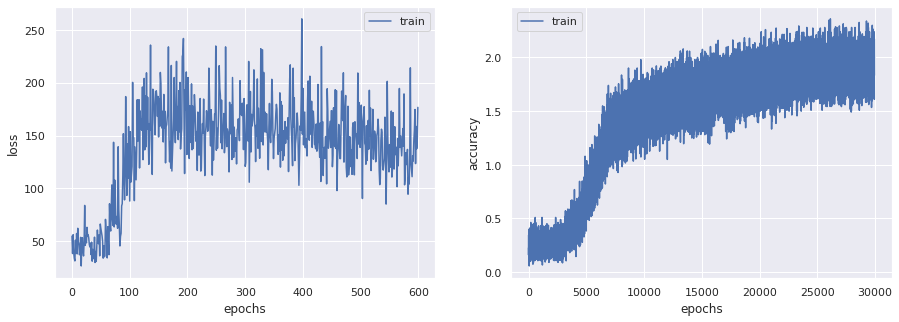

In [47]:
n_epochs = 30000
n_fields = 16

train(n_epochs, n_fields, model, bob_model, optimizer, bob_optimizer, pad_chosen=pad_chosen)

### Samples

In [184]:
alice_field, bob_field = get_batch(4, word_vectors, pad_chosen)

In [185]:
for i in range(len(get_batch.fields)):
    print(f'Field #{i}')
    pprint(get_batch.fields[i])
    print('--------------------')

Field #0
{'black': 'flea',
 'blue': {'Day': ['friday', 'monday', 'sunday'],
          'Flower': ['mimosa', 'orchid', 'jasmine'],
          'Month': ['may', 'april']},
 'neutral': ['shirt',
             'golf',
             'cylinder',
             'goose',
             'drum',
             'beans',
             'mexico',
             'france',
             'cucumber',
             'seagull',
             'carrot',
             'kiwi',
             'blouse',
             'aluminum',
             'physics',
             'geology']}
--------------------
Field #1
{'black': 'horse',
 'blue': {'Body': ['heart', 'hand'],
          'Head': ['nose', 'wrinkles', 'forehead'],
          'Music': ['notes', 'opera', 'organ']},
 'neutral': ['football',
             'salad',
             'hawk',
             'bear',
             'strawberry',
             'sunday',
             'beans',
             'duck',
             'cardigan',
             'hat',
             'spinach',
             'rectangle',


In [186]:
import pandas as pd

In [187]:
def get_log(alice_field, bob_field, cout=False):
    df = {'alice_gt': [], 'alice_hints': [], 'bob_gt': [], 'bob_predictions': []}
    
    if cout:
        print('Groud trurh:')
    for i, a in enumerate(alice_field['label']):
        df['alice_gt'].append(idx2category[a])
        if cout:
            print(f'Hint for field #{i}: {idx2category[a]}')
    
    blue_tensor = torch.as_tensor(alice_field['blue'], dtype=torch.float32, device=device).permute(1, 0, 2)
    neutral_tensor = torch.as_tensor(alice_field['neutral'], dtype=torch.float32, device=device).permute(1, 0, 2)
    black_tensor = torch.as_tensor(alice_field['black'], dtype=torch.float32, device=device)
    labels = torch.as_tensor(alice_field['label'], dtype=torch.long, device=device)
    
    qvalues = model(blue_tensor, neutral_tensor, black_tensor)
    actions = sample_action(qvalues, 0)
    
    hints = model.categories_embs[actions]
    bob_field_tensor = torch.as_tensor(bob_field['field'], dtype=torch.float32, device=device).permute(1, 0, 2)
    
    # Given hints:
    if cout:
        print('')
        print('Alice hints:')
    for i, a in enumerate(actions.cpu().data.numpy()):
        df['alice_hints'].append(idx2category[a])
        if cout:
            print(f'Hint for field #{i}: {idx2category[a]}')
    
    if cout:
        print('')
        print('Bob ground truth: ')
    for i, labels in enumerate(bob_field['label']):
        if cout:
            print(f'Field #{i} correct words:')
        bob_gt = []
        for label in labels:
            if cout:
                print(bob_field['field_words'][i][label], end=' ')
            bob_gt.append(bob_field['field_words'][i][label])
        df['bob_gt'].append(bob_gt)
        if cout:
            print('\n--------------------')
    
    bob_qvalues = bob_model(bob_field_tensor, hints)
    bob_actions = []
    for i, qvalues in enumerate(bob_qvalues):
        gt = bob_field['label'][i]
        bob_actions.append(sample_bob_action(qvalues, 0, k=len(gt)))
    
    if cout:
        print('')
        print('Bob prediction: ')
    for i, labels in enumerate(bob_actions):
        labels = labels.cpu().data.numpy()
        if cout:
            print(f'Field #{i} predictions:')
        bob_gt = []
        for label in labels:
            if cout:
                print(bob_field['field_words'][i][label], end=' ')
            bob_gt.append(bob_field['field_words'][i][label])
        df['bob_predictions'].append(bob_gt)
        if cout:
            print('\n--------------------')
    return pd.DataFrame(df)

In [188]:
log = get_log(alice_field, bob_field)

In [189]:
log

,alice_gt,alice_hints,bob_gt,bob_predictions
0,Day,Sport,"[friday, monday, sunday]","[sunday, monday, friday]"
1,Flower,Head,"[mimosa, orchid, jasmine]","[jasmine, orchid, mimosa]"
2,Month,Computer,"[may, april]","[april, monday]"
3,Music,Gases,"[notes, opera, organ]","[opera, organ, notes]"
4,Head,Flower,"[nose, wrinkles, forehead]","[sandwich, salad, wrinkles]"
5,Body,Sport,"[heart, hand]","[hand, heart]"
6,Crime,Day,"[prison, jail, lawyer, gun]","[gun, jail, prison, lawyer]"
7,Shape,Computer,"[hexagon, pentagon, triangle]","[hexagon, pentagon, triangle]"
8,Body,Sport,[hand],[hand]
9,Music,Gases,"[piano, guitar]","[guitar, piano]"
